In [1]:
import pandas as pd
import tensorflow as tf
import librosa
from sklearn.model_selection import train_test_split
import numpy as np



2024-04-17 18:20:11.384771: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-17 18:20:11.408984: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 18:20:11.409009: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 18:20:11.409747: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-17 18:20:11.414500: I tensorflow/core/platform/cpu_feature_guar

In [2]:
dataset_df = pd.read_csv('dataset.csv').to_numpy()
sounds_dataset = dataset_df[:, 0]
sr = 0
for i in range(len(sounds_dataset)):
    sounds_dataset[i], sr = librosa.load(f'Noisy-sounds/{sounds_dataset[i]}.wav')

label_dataset = dataset_df[:, 1]
for i in range(len(label_dataset)):
    label_dataset[i], sr = librosa.load(f'Clean-sounds/{label_dataset[i]}.wav')

X_train, X_test, y_train, y_test = train_test_split(sounds_dataset, label_dataset, test_size=0.1, random_state=42)



In [3]:
def to_spectogram(sound):
    stft = librosa.stft(sound.astype(np.float64), n_fft = 256, hop_length=128)
    stft = np.abs(stft)
    db = librosa.amplitude_to_db(stft, ref=np.max)
    return db
    # print(db)
    # librosa.display.specshow(db, y_axis='log', x_axis='time')


In [4]:
spectogram_train = []
for x in X_train:
    spectogram_train.append(to_spectogram(x))
spectogram_label = []
for x in y_train:
    spectogram_label.append(to_spectogram(x))
spectogram_val = []
for x in X_test:
    spectogram_val.append(to_spectogram(x))
spectogram_val_label = []
for x in y_test:
    spectogram_val_label.append(to_spectogram(x))



In [5]:
max_len = 0
for x in spectogram_train:
    max_len = max(max_len, len(x[0]))
for x in spectogram_label:
    max_len = max(max_len, len(x[0]))
for x in spectogram_val:
    max_len = max(max_len, len(x[0]))
for x in spectogram_val_label:
    max_len = max(max_len, len(x[0]))
print(max_len)

863


In [6]:
def pad_vector(vec):
    for i in range(len(vec)):
        vec[i] = np.pad(vec[i], ((0, 0), (0, max_len - len(vec[i][0]))))
    return vec

In [7]:
spectogram_train = pad_vector(spectogram_train)
spectogram_label = pad_vector(spectogram_label)
spectogram_val = pad_vector(spectogram_val)
spectogram_val_label = pad_vector(spectogram_val_label)


In [8]:
spectogram_train = np.array(spectogram_train)
spectogram_label = np.array(spectogram_label)
spectogram_val = np.array(spectogram_val)
spectogram_val_label = np.array(spectogram_val_label)

In [9]:
spectogram_train = spectogram_train / -80
spectogram_label = spectogram_label / -80
spectogram_val = spectogram_val / -80
spectogram_val_label = spectogram_val_label / -80

In [10]:
print(spectogram_train.shape)

(5675, 129, 863)


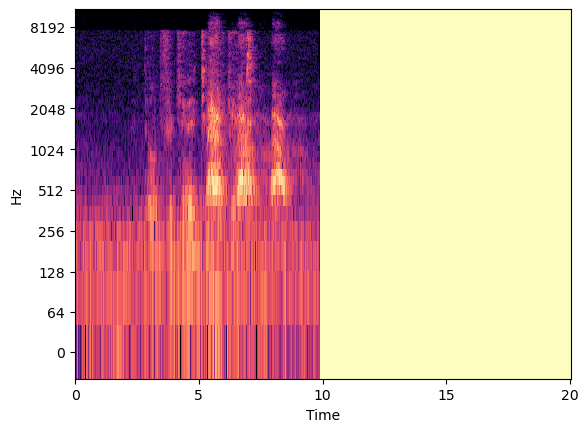

In [11]:
test = spectogram_train[0] * -80
librosa.display.specshow(test, y_axis='log', x_axis='time')

In [12]:
to_spectogram(X_train[0])

array([[-48.87827506, -30.76394261, -50.2082908 , ..., -36.83999055,
        -38.3575437 , -37.96956034],
       [-37.838238  , -26.51338154, -31.8250759 , ..., -30.86195013,
        -31.79447788, -41.75488833],
       [-34.41648103, -28.29701582, -24.03368903, ..., -31.10269617,
        -33.0766842 , -53.91818598],
       ...,
       [-80.        , -80.        , -80.        , ..., -80.        ,
        -80.        , -80.        ],
       [-80.        , -80.        , -80.        , ..., -80.        ,
        -80.        , -80.        ],
       [-80.        , -80.        , -80.        , ..., -80.        ,
        -80.        , -80.        ]])

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Cropping2D, BatchNormalization, LeakyReLU, Dropout, concatenate, Flatten, Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow import keras
# Define the dimensions of the input data
input_shape = (129, 863, 1)  # MNIST dataset has 28x28 grayscale images

# go through 10 Conv2D layers to modify the input image
#Encoder part
input_data = keras.layers.Input(shape=input_shape)

encoder = keras.layers.Conv2D(64, (5,5), activation='relu')(input_data)
encoder = keras.layers.MaxPooling2D((2,2))(encoder)
encoder = keras.layers.Conv2D(128, (3,3), activation='relu')(encoder)
#Decoder Part
decoder = keras.layers.Conv2DTranspose(256, (3,3), padding='same', activation='relu')(encoder)
decoder = keras.layers.UpSampling2D((2,2))(decoder)
decoder = keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder)
decoder = keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder)
decoder = keras.layers.Conv2DTranspose(32, (3,3), activation='relu')(decoder)
decoder = keras.layers.Conv2DTranspose(1, (6,6), activation='tanh')(decoder)
decoded = keras.layers.Cropping2D(cropping=((0, 2), (0, 2)))(decoder)


model = Model(inputs=input_data, outputs=decoded)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


2024-04-17 18:22:22.806532: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-17 18:22:22.819995: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-17 18:22:22.820034: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-17 18:22:22.821986: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-17 18:22:22.822022: I external/local_xla/xla/stream_executor

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 129, 863, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 125, 859, 64)      1664      
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 429, 64)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 427, 128)      73856     
                                                                 
 conv2d_transpose (Conv2DTr  (None, 60, 427, 256)      295168    
 anspose)                                                        
                                                                 
 up_sampling2d (UpSampling2  (None, 120, 854, 256)     0     

/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-17 18:22:22.932149: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-17 18:22:22.932196: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-17 18:22:22.932201: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2022] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.
2024-04-17 18:22:22.932231: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000

In [14]:
history = model.fit(spectogram_train, spectogram_label,
                epochs=15,
                batch_size=16,
                shuffle=True,
                validation_data=(spectogram_val, spectogram_val_label),)

Epoch 1/15


2024-04-17 18:22:40.074152: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-04-17 18:22:40.149732: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-17 18:22:42.190824: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-17 18:22:52.217872: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.13GiB (rounded to 3358064640)requested by op gradient_tape/model/conv2d_transpose_1/conv2d_transpose/Conv2DBackpropFilter-2-TransposeNHWCToNCHW-LayoutOptimizer
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-04-17 18:22:52.217903: I external/local_tsl/tsl/framework/bfc_alloca

ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/model/conv2d_transpose_1/conv2d_transpose/Conv2DBackpropFilter-2-TransposeNHWCToNCHW-LayoutOptimizer defined at (most recent call last):
<stack traces unavailable>
OOM when allocating tensor with shape[32,256,120,854] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/model/conv2d_transpose_1/conv2d_transpose/Conv2DBackpropFilter-2-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1945]

In [ ]:
sample, sr = librosa.load('Noisy-sounds/Sound1.wav')
sample = to_spectogram(sample)
sample = np.array(sample)
sample = np.pad(sample, ((0, 0), (0, max_len - len(sample[0]))))
sample = np.expand_dims(sample, axis=0)
sample = sample / -80

In [ ]:
prediction = model.predict(sample)
print(prediction.shape)
print(np.min(prediction))

In [ ]:
import soundfile as sf
#prediction = librosa.db_to_amplitude(prediction)
prediction = np.squeeze(prediction)
prediction = prediction * -80
librosa.display.specshow(prediction, y_axis='log', x_axis='time')
prediction = librosa.istft(prediction, hop_length=128, n_fft=256)
print(prediction.shape)


In [ ]:
print(np.max(prediction))

In [ ]:
target, sr = librosa.load('Clean-sounds/1087_MTI_DIS_XX.wav')
target = to_spectogram(target)
librosa.display.specshow(target, y_axis='log', x_axis='time')

In [ ]:
sf.write('test_denoised.wav', prediction, sr)